# Statistics for Business - Salary Regression Model

**Load data**

In [1]:
# load data
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# modelling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# cross validation using statsmodel preparation
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, cross_validate, KFold

**Function**

In [2]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :return df: <pandas DataFrame> combined estimated coefficient and standard error of model estimate
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

# 1. Persiapan Data

**Membaca data**

In [3]:
df_salary = pd.read_csv("salary_data.csv")
df_salary.rename(columns = {'Education Level':'EducationLevel', 'Years of Experience':'YearsOfExperience'}, inplace=True)
df_salary

,Age,Gender,EducationLevel,Job Title,YearsOfExperience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0
371,43.0,Male,Master's,Director of Operations,19.0,170000.0
372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0
373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0


## 1.1. Handling Missing Value

**Mengecek missing value**

In [4]:
df_salary.isna().sum()

Age                  2
Gender               2
EducationLevel       2
Job Title            2
YearsOfExperience    2
Salary               2
dtype: int64

In [5]:
df_salary.shape

(375, 6)

In [6]:
df_salary[df_salary["Age"].isna()]

,Age,Gender,EducationLevel,Job Title,YearsOfExperience,Salary
172,NaN,NaN,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN,NaN,NaN


**Menghapus missing value**

In [7]:
df_salary = df_salary.dropna()

In [8]:
df_salary.isna().sum()

Age                  0
Gender               0
EducationLevel       0
Job Title            0
YearsOfExperience    0
Salary               0
dtype: int64

In [9]:
df_salary.shape

(373, 6)

## 1.2. Handling Duplicated Data

**Mengecek duplicated data**

In [10]:
df_salary.duplicated().sum()

49

In [11]:
df_salary[df_salary.duplicated(keep=False)]

,Age,Gender,EducationLevel,Job Title,YearsOfExperience,Salary
140,28.0,Male,Bachelor's,Junior Business Analyst,2.0,40000.0
195,28.0,Male,Bachelor's,Junior Business Analyst,2.0,40000.0
209,30.0,Female,Bachelor's,Junior Marketing Coordinator,2.0,40000.0
210,38.0,Male,Master's,Senior IT Consultant,9.0,110000.0
211,45.0,Female,PhD,Senior Product Designer,15.0,150000.0
...,...,...,...,...,...,...
369,33.0,Male,Bachelor's,Junior Business Analyst,4.0,60000.0
370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0
372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0
373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0


**Menghapus duplicated data**

In [12]:
df_salary = df_salary.drop_duplicates(keep="first")
df_salary.duplicated().sum()

0

In [13]:
df_salary

,Age,Gender,EducationLevel,Job Title,YearsOfExperience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
348,28.0,Female,Bachelor's,Junior Operations Manager,1.0,35000.0
349,36.0,Male,Bachelor's,Senior Business Development Manager,8.0,110000.0
350,44.0,Female,PhD,Senior Data Scientist,16.0,160000.0
351,31.0,Male,Bachelor's,Junior Marketing Coordinator,3.0,55000.0


# 2. Deskripsi Data

In [14]:
df_salary.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,324.0,37.382716,7.185844,23.0,31.0,36.5,44.0,53.0
YearsOfExperience,324.0,10.058642,6.650470,0.0,4.0,9.0,16.0,25.0
Salary,324.0,99985.648148,48652.271440,350.0,55000.0,95000.0,140000.0,250000.0


In [15]:
df_salary["Gender"].value_counts()

Male      170
Female    154
Name: Gender, dtype: int64

In [16]:
df_salary["EducationLevel"].value_counts()

Bachelor's    191
Master's       91
PhD            42
Name: EducationLevel, dtype: int64

In [17]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 371
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                324 non-null    float64
 1   Gender             324 non-null    object 
 2   EducationLevel     324 non-null    object 
 3   Job Title          324 non-null    object 
 4   YearsOfExperience  324 non-null    float64
 5   Salary             324 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB


## 2.1. Correlation in Numerical Variables

In [18]:
df_salary[["Age","YearsOfExperience", "Salary"]].corr()

,Age,YearsOfExperience,Salary
Age,1.000000,0.979192,0.916543
YearsOfExperience,0.979192,1.000000,0.924455
Salary,0.916543,0.924455,1.000000


Korelasi antara usia, lama pengalaman kerja, dan gaji memiliki hasil positif dan berkorelasi kuat.

## 2.2. Average salary in each categorical variables

**Perbandingan salary antar gender.**

In [19]:
df_salary.groupby("Gender")["Salary"].mean()

Gender
Female     96136.363636
Male      103472.647059
Name: Salary, dtype: float64

Rata-rata gaji laki-laki lebih besar dari rata-rata gaji perempuan.

**Perbandingan salary antar education level.**

In [20]:
df_salary.groupby("EducationLevel")["Salary"].mean()

EducationLevel
Bachelor's     73902.356021
Master's      127912.087912
PhD           158095.238095
Name: Salary, dtype: float64

Rata-rata gaji semakin besar seiring dengan level pendidikan yang lebih tinggi.

## 2.3. Numerical Variables with Each Categorical Variable

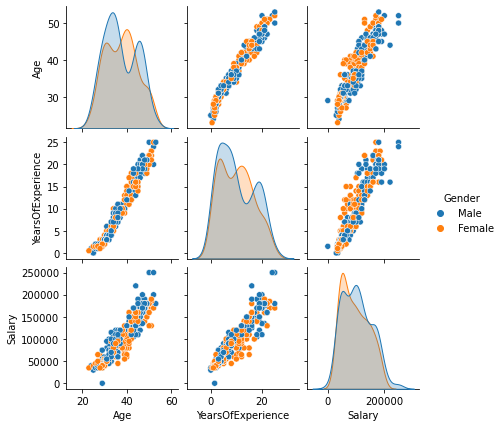

In [21]:
sns.pairplot(data = df_salary, hue = "Gender", height=2)

- Semakin lama pengalaman kerja seseorang, semakin tinggi gajinya.
- Semakin tua usia seseorang, semakin lama pula pengalaman kerja yang dimiliki.
- Jenis kelamin tidak terlalu berdampak signifikan pada gaji.

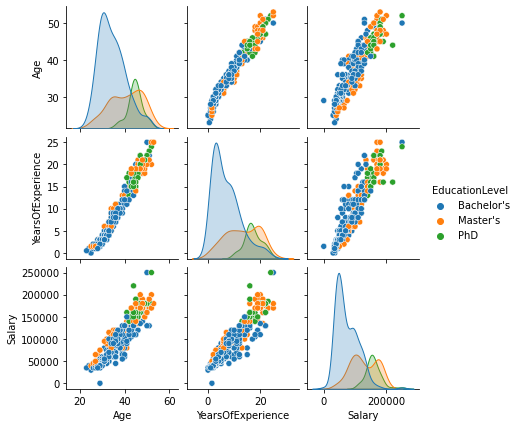

In [22]:
sns.pairplot(data = df_salary, hue = "EducationLevel", height=2, palette="tab10")

- Semakin tinggi tingkat pendidikan seseorang, semakin tinggi gajinya.
- Tingkat pendidikan yang tinggi cenderung dimiliki seseorang dengan usia yang lebih tua.
- Tingkat pendidikan yang tinggi cenderung dimiliki oleh seseorang dengan lama pengalaman kerja yang tinggi pula.

# 3. Uji Statistik

$H_0$: Rata-rata gaji laki-laki sama dengan dari rata-rata gaji perempuan.
$$ H_0:\mu_A = \mu_B $$

$H_1$: Rata-rata gaji laki-laki lebih besar dari rata-rata gaji perempuan.
$$ H_1:\mu_A > \mu_B $$

In [23]:
significance_level = 0.10

## 3.1. Preanalysis

In [24]:
# Menghitung jumlah data laki-laki dan perempuan
df_salary.groupby("Gender")["Salary"].mean()

Gender
Female     96136.363636
Male      103472.647059
Name: Salary, dtype: float64

Rata-rata gaji laki-laki lebih besar dari rata-rata gaji perempuan.

## 3.2. Analysis

Karena standar deviasi populasi tidak diketahui, digunakan t-test.
Sebelum menggunakan t-test, dilakukan uji variansi.

In [25]:
# Gaji Laki-laki
df_male = df_salary[df_salary["Gender"]=="Male"]["Salary"].values

# Gaji Perempuan
df_female = df_salary[df_salary["Gender"]=="Female"]["Salary"].values

# Variansi
np.var(df_male), np.var(df_female)

(2571353207.6989617, 2097896989.374262)

Dapat disimpulkan bahwa variansi tidak sama.

In [26]:
from scipy import stats
result = stats.ttest_ind(a = df_male, 
                         b = df_female, 
                         equal_var=False, 
                         alternative = "greater")

In [27]:
result.pvalue

0.08675461782037655

In [28]:
result.statistic

1.364034982496829

In [29]:
# Menentukan aturan keputusan
if result.pvalue<significance_level:
    print("Tolak hipotesis nol.")
else:
    print("Gagal menolak hipotesis nol.")

Tolak hipotesis nol.


Terdapat cukup bukti bahwa rata-rata gaji laki-laki dan perempuan tidak sama.
Rata-rata gaji laki-laki lebih tinggi dan rata-rata gaji perempuan.

## 3.3. Derajat Kebebasan

In [30]:
df_data = len(df_male)+len(df_female)
df_data

324

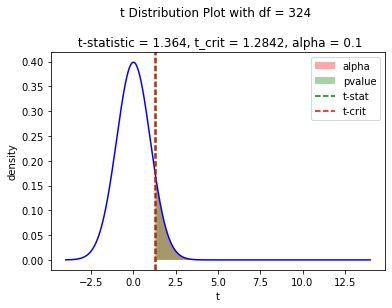

In [31]:
# plot sample distribution 
x = np.arange(-4, 14, 0.001)
plt.plot(x, stats.t.pdf(x, df = df_data), 
         color='blue')

# plot alpha region
x_alpha = np.arange(stats.t.ppf(1-significance_level, df = df_data), 4, 0.01)
y_alpha = stats.t.pdf(x_alpha, df = df_data)
plt.fill_between(x = x_alpha, 
                 y1 = y_alpha,
                 facecolor = 'red',
                 alpha = 0.35, 
                 label = 'alpha')

# plot pvalue
x_pvalue = np.arange(result.statistic, 4, 0.01)
y_pvalue = stats.t.pdf(x_pvalue, df = df_data)

plt.fill_between(x = x_pvalue, 
                 y1 = y_pvalue,
                 facecolor = 'green',
                 alpha = 0.35, 
                 label = 'pvalue')

# plot t-crit and t-stats
plt.axvline(np.round(result.statistic, 4), 
            color ="green", 
            linestyle = "--", 
            label ="t-stat")

t_crit = np.round(stats.t.ppf(1-significance_level, df = df_data), 4)
plt.axvline(t_crit, 
            color ="red", 
            linestyle = "--", 
            label ="t-crit")

plt.legend()
plt.xlabel("t")
plt.ylabel("density")


plt.title(f't Distribution Plot with df = {df_data} \n\n t-statistic = {np.round(result.statistic, 4)}, t_crit = {np.round(t_crit,4)}, alpha = {significance_level}');

## 3.4. Confidence Level

In [32]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

cm = CompareMeans(d1 = DescrStatsW(data=df_male), 
                  d2 = DescrStatsW(data=df_female))

lower, upper = cm.tconfint_diff(alpha=significance_level, 
                                alternative='two-sided', 
                                usevar='unequal')

print("Confidence Interval", ":", "[", lower, upper, "]")

Confidence Interval : [ -1535.8717753119818 16208.438620231766 ]


Dari hasil yang didapat, disimpulkan bahwa kita 90% yakin bahwa rata-rata gaji laki-laki lebih dari rata-rata gaji perempuan.
Dari confidence interval yang didapat, disimpulkan kita 90% yakin bahwa rata-rata perbedaan gaji memiliki interval di -1535 sampai dengan 16208.

# 4. Regression Modelling

## 4.1. Persiapan Data

### a. Menghapus kolom Job Title karena tidak akan digunakan

In [33]:
df_salary.drop("Job Title", axis=1, inplace=True)
df_salary.head()

,Age,Gender,EducationLevel,YearsOfExperience,Salary
0,32.0,Male,Bachelor's,5.0,90000.0
1,28.0,Female,Master's,3.0,65000.0
2,45.0,Male,PhD,15.0,150000.0
3,36.0,Female,Bachelor's,7.0,60000.0
4,52.0,Male,Master's,20.0,200000.0


### b. Mengubah Data Kategorik Menjadi Numerik

#### Cek Isi Data Education Level

In [34]:
df_salary["EducationLevel"].value_counts()

Bachelor's    191
Master's       91
PhD            42
Name: EducationLevel, dtype: int64

#### Cek Isi Data Gender

In [35]:
df_salary["Gender"].value_counts()

Male      170
Female    154
Name: Gender, dtype: int64

#### Mengubah Data

Gender (binary):
Male = 0,
Female = 1

Education Level (ordinal):
Bachelor's = 0,
Master's = 1,
PhD = 2

In [36]:
df_salary["EducationLevel"] = df_salary["EducationLevel"].map({"Bachelor's":0,"Master's":1,"PhD":2})
df_salary["Gender"] = df_salary["Gender"].map({"Male":0,"Female":1})
df_salary.head()

,Age,Gender,EducationLevel,YearsOfExperience,Salary
0,32.0,0,0,5.0,90000.0
1,28.0,1,1,3.0,65000.0
2,45.0,0,2,15.0,150000.0
3,36.0,1,0,7.0,60000.0
4,52.0,0,1,20.0,200000.0


## 4.2. Single Predictor Modelling

Melihat hubungan antara lama pengalaman kerja dengan gaji.

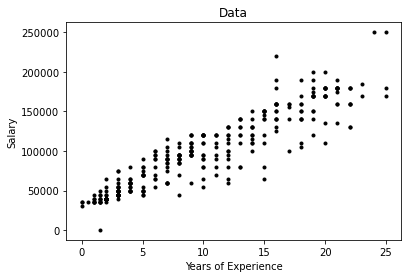

In [37]:
x = df_salary["YearsOfExperience"]
y = df_salary["Salary"]

# Plot the data
plt.scatter(x, y, color = "k", marker=".")

# Add a legend and labels
plt.xlabel("Years of Experience")
plt.ylabel("Salary")

# Add a title and adjust the margins
plt.title("Data")

# Show the plot
plt.show()

Menunjukkan hubungan positif yaitu semakin lama pengalaman kerja, semkain tinggi gaji.
Untuk pengalaman kerja yang lebih lama, variasi gaji cenderung lebih besar.

### a. Fit Linear Regression - Using Horsepower Variable

In [38]:
# Create OLS model object
model = smf.ols("Salary ~ YearsOfExperience", df_salary)

# Fit the model
results_model_salary = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_salary = print_coef_std_err(results_model_salary)
results_salary

,coef,std err
Intercept,31959.508721,1873.552736
YearsOfExperience,6762.954641,155.446221


In [39]:
results_model_salary.rsquared

0.8546166681460778

$$\text{Salary} = 31960 + 6763\times\text{Years of Experience}$$

Jika membandingkan dua orang yang memiliki 1 tahun perbedaan pada lama pengalaman kerja, diperkirakan orang yang memiliki pengalaman kerja lebih lama memiliki gaji yang lebih besar dengan selisih 6763.

Untuk seseorang yang memiliki lama pengalaman kerja 0 tahun, perkiraan rata-rata gaji yang didapatkan adalah sebesar 31960.

**Visualisasi**

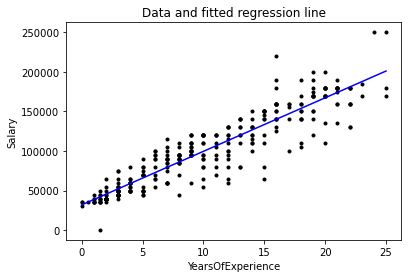

In [40]:
predictor = "YearsOfExperience"
outcome = "Salary"
data = df_salary.copy()
results_ = results_salary.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
# plt.legend()
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

**Residual plot**

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

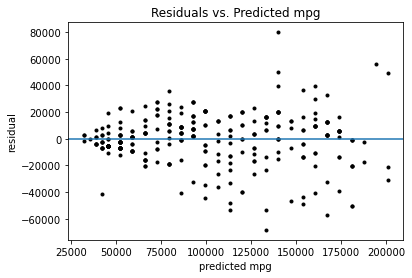

In [41]:
# Residual Plot and Explained Variance
plt.scatter(results_model_salary.fittedvalues, results_model_salary.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

In [42]:
results_model_salary.rsquared

0.8546166681460778

Residual menghasilkan pola yang terlihat jelas, hal ini membuat ketidaksesuaian lebih terlihat meskipun garis regresi menjelaskan lebih dari 85% variansi lama pengalaman kerja.

**Normality of Error Assumption**

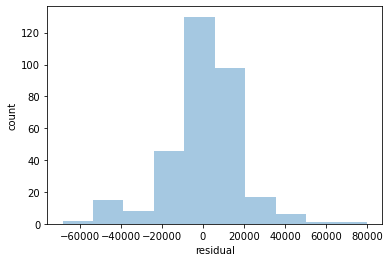

In [43]:
# Normality of Error Assumption

plt.hist(results_model_salary.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

### b. Fit Linear Regression - Using Log Transform on Weight Variable

In [44]:
df_salary["logYOE"] = np.log(df_salary["YearsOfExperience"])
df_salary.loc[df_salary["YearsOfExperience"] == 0, "logYOE"] = 0
df_salary.describe().transpose()

D:\Programs\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,count,mean,std,min,25%,50%,75%,max
Age,324.0,37.382716,7.185844,23.000000,31.000000,36.500000,44.000000,53.000000
Gender,324.0,0.475309,0.500162,0.000000,0.000000,0.000000,1.000000,1.000000
EducationLevel,324.0,0.540123,0.713597,0.000000,0.000000,0.000000,1.000000,2.000000
YearsOfExperience,324.0,10.058642,6.650470,0.000000,4.000000,9.000000,16.000000,25.000000
Salary,324.0,99985.648148,48652.271440,350.000000,55000.000000,95000.000000,140000.000000,250000.000000
logYOE,324.0,2.005576,0.874208,-0.693147,1.386294,2.197225,2.772589,3.218876


In [45]:
# Create OLS model object
model = smf.ols("Salary ~ logYOE", df_salary)

# Fit the model
results_logtransform = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_salary_log = print_coef_std_err(results_logtransform)
results_logtransform.rsquared

0.7656239539695425

Nilai R Squared regresi linier dengan transformasi log lebih kecil daripada tanpa transformasi.
Performa regresi tanpa transformasi lebih baik.

## 4.3. Multiple Predictors Modelling

**Data preparation**

In [46]:
# Mengembalikan data tabel
df_salary.drop("logYOE", axis=1, inplace=True)
df_salary.head()

,Age,Gender,EducationLevel,YearsOfExperience,Salary
0,32.0,0,0,5.0,90000.0
1,28.0,1,1,3.0,65000.0
2,45.0,0,2,15.0,150000.0
3,36.0,1,0,7.0,60000.0
4,52.0,0,1,20.0,200000.0


In [47]:
class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param data: <pandas DataFrame> 
    :param n_fold: <int> Number of fold in k-fold CV
    :return fold_train: <pandas DataFrame> Training Data
    :return fold_test: <pandas DataFrame> Testing Data
    """
    kfold = KFold(n_splits = n_fold, 
                  shuffle = True, 
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
        
    return (fold_train, fold_test)

### Evaluate a model using K-fold cross validation

In [48]:
# Create a class model
ols_all_pred = StatsmodelsRegressor(smf.ols, "Salary ~ Age + Gender + C(EducationLevel) + YearsOfExperience + Age:YearsOfExperience")

# Create k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

scores_ols_all_pred = cross_val_score(estimator = ols_all_pred,
                                       X = df_salary,
                                       y = df_salary["Salary"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, 
                                    columns=["test_rsquared"])
scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.892141,Folds 1
1,0.902729,Folds 2
2,0.912515,Folds 3
3,0.825113,Folds 4
4,0.897267,Folds 5


In [49]:
scores_ols_all_pred["test_rsquared"].mean()

0.8859529642576728

The model use all media have good fit, it can explain 88.59% variance of salary. Let's build the model using whole data to infer the estimated coefficient from the model, and gain the insight from business prespective

## Fit Linear Regression - Using All Predictors

In [50]:
# Create OLS model object
model = smf.ols("Salary ~ Age + Gender + C(EducationLevel) + YearsOfExperience + Age:YearsOfExperience", df_salary)

# Fit the model
results_model_salary = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_salary = print_coef_std_err(results_model_salary)
results_salary

,coef,std err
Intercept,-44159.185552,16580.736611
C(EducationLevel)[T.1],19574.074815,2257.344892
C(EducationLevel)[T.2],26339.473807,3160.610738
Age,3042.039143,611.919060
Gender,-9310.571777,1766.475849
YearsOfExperience,2433.641886,1211.995905
Age:YearsOfExperience,3.452762,21.044653


Nilai intercept negatif sehingga kurang bermakna.

### Melakukan Centering Predictor Age

Centering dilakukan agar interpretasi hasil regresi lebih baik.

In [51]:
mean_age = df_salary["Age"].mean()
mean_age = np.round(mean_age,0)
mean_age

37.0

In [52]:
df_salary["Age"] = df_salary["Age"]-mean_age
df_salary.rename(columns = {"Age":"AgeCentered"}, inplace=True)
df_salary.head()

,AgeCentered,Gender,EducationLevel,YearsOfExperience,Salary
0,-5.0,0,0,5.0,90000.0
1,-9.0,1,1,3.0,65000.0
2,8.0,0,2,15.0,150000.0
3,-1.0,1,0,7.0,60000.0
4,15.0,0,1,20.0,200000.0


In [53]:
# Create a class model
ols_all_pred = StatsmodelsRegressor(smf.ols, "Salary ~ AgeCentered + Gender + C(EducationLevel) + YearsOfExperience + AgeCentered:YearsOfExperience")

# Create k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=12)

scores_ols_all_pred = cross_val_score(estimator = ols_all_pred,
                                       X = df_salary,
                                       y = df_salary["Salary"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, 
                                    columns=["test_rsquared"])
scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.849681,Folds 1
1,0.907836,Folds 2
2,0.873470,Folds 3
3,0.938117,Folds 4
4,0.881399,Folds 5


In [54]:
scores_ols_all_pred["test_rsquared"].mean()

0.8901007028969221

The model use all media have good fit, it can explain 89% variance of salary. Let's build the model using whole data to infer the estimated coefficient from the model, and gain the insight from business prespective.

In [55]:
# Create OLS model object
model = smf.ols('Salary ~ AgeCentered + Gender + C(EducationLevel) + YearsOfExperience + AgeCentered:YearsOfExperience', df_salary)

# Fit the model
results = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_salary = print_coef_std_err(results)
results_salary

,coef,std err
Intercept,68396.262743,6722.803498
C(EducationLevel)[T.1],19574.074815,2257.344892
C(EducationLevel)[T.2],26339.473807,3160.610738
AgeCentered,3042.039143,611.919060
Gender,-9310.571777,1766.475849
YearsOfExperience,2561.394070,714.405923
AgeCentered:YearsOfExperience,3.452762,21.044653


$$\text{Salary for Bachelor's} = 68396 + 3042\times\text{(Age - 37)} - 9311\times\text{Gender} + 2561\times\text{YearsOfExperience} + 3\times\text{(Age - 37)}\times\text{YearsOfExperience} $$

$$\text{Salary for Master's} = 68396+ 19574 + 3042\times\text{(Age - 37)} - 9311\times\text{Gender} + 2561\times\text{YearsOfExperience} + 3\times\text{(Age - 37)}\times\text{YearsOfExperience} $$

$$\text{Salary for PhD} = 68396 + 26339 + 3042\times\text{(Age - 37)} - 9311\times\text{Gender} + 2561\times\text{YearsOfExperience} + 3\times\text{(Age - 37)}\times\text{YearsOfExperience} $$

**Interpretasi tingkat pendidikan**


Jika membandingkan dua orang yang memiliki usia, jenis kelamin, lama pengalaman kerja yang sama, gaji seseorang dengan tingkat pendidikan Master's diperkirakan lebih tinggi 19574 dollar daripada gaji seseorang dengan tingkat pendidikan Bachelor's.

**Interpretasi usia**

Jika membandingkan dua orang yang memiliki jenis kelamin dan tingkat pendidikan yang sama, serta pengalaman kerja 0 tahun, seseorang yang usianya 1 tahun lebih tua dari 37 tahun diperkirakan memiliki gaji lebih tinggi 3042 dollar daripada seseorang berusia 37 tahun.

**Interpretasi jenis kelamin**

Jika membandingkan dua orang yang memiliki usia, lama pengalaman kerja, dan tingkat pendidikan yang sama, perempuan diperkiraan memiliki gaji lebih sedikit 9311 dollar dibandingkan laki-laki.

**Interpretasi lama pengalaman kerja**

Jika membandingkan dua orang berusia 37 tahun yang memiliki jenis kelamin dan tingkat pendidikan yang sama, seseorang dengan lama pengalaman kerja lebih lama 1 tahun diperkirakan memiliki gaji lebih tinggi 2561 dollar.

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

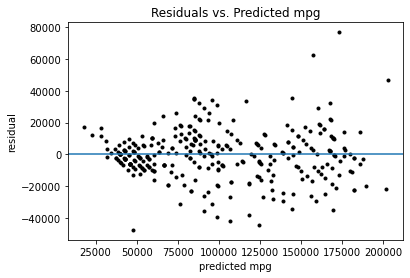

In [56]:
# Residual Plot and Explained Variance
plt.scatter(results.fittedvalues, results.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

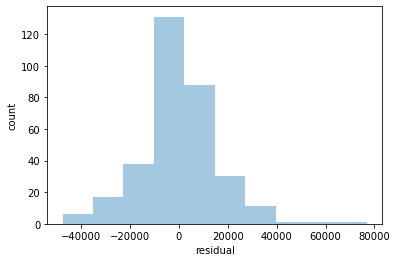

In [58]:
# Normality of Error Assumption

plt.hist(results.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()